# 本筆記內容：利用批次梯度下降法(Mini-batch Gradient Descent)實作線性迴歸。

我們希望讀者能透過此範例，來理解監督式機器學習的基本概念，包含：
   * 監督式機器學習即是最小化Loss函數。此範例中，Loss函數為Mean squared error。
   * 如何利用Mini-batch Gradient Descent更新權重。
   * L1(Lasso)的功用。
---
   
# 索引
[1.定義資料載入以及權重更新函數](#1.-定義資料載入以及權重更新函數)

[2. 定義專門用來處理線性迴歸的類別](#2.-定義專門用來處理線性迴歸的類別)

[3. 準備測試資料](#3.-準備測試資料)

[4. 開始對資料做線性回歸](#4.-開始對資料做線性回歸)

[5. 改變C, 由10000至10, 看回歸結果如何變化](#5.-改變C,-由10000至10,-看回歸結果如何變化)
  * [5.a. 將回歸結果繪圖](#5.a.-將回歸結果繪圖)
  * [5.b. 將權重繪圖](#5.b.-將權重繪圖)
---

In [1]:
from autograd import grad
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pandas as pd

$f(x) = x^2$

$f'(x) = 2x$

In [2]:
func = lambda x:x**2

In [9]:
diffed_func = grad(func)

In [11]:
func(3.)

9.0

In [10]:
diffed_func(3.)

6.0

## 1. 定義資料載入以及權重更新函數

In [38]:
it = (range(0,5,2)).__iter__()   # 等同於 iter(range(5))

In [39]:
next(it)

0

In [40]:
next(it)

2

In [41]:
next(it)

4

In [42]:
next(it)

StopIteration: 

In [96]:
for j in range(5):
    print(j)

0
1
2
3
4


In [44]:
def dataLoader(x,y,batch_size,shuffle=True):
    '''此函數負責批次性的拋出資料(資料的量為batch_size)給機器學習的演算法做訓練。'''
    
    num_batches=y.shape[0]//batch_size
    data=np.hstack((x,y.reshape(-1,1)))
    
    if shuffle==True:
        np.random.shuffle(data)
    for j in range(num_batches):
        x_batch= data[batch_size*j:batch_size*(j+1),0:x.shape[1]]
        y_batch= data[batch_size*j:batch_size*(j+1),x.shape[1]]
        yield x_batch,y_batch

In [47]:
x = np.random.normal(0,1,(256,10))
x.shape

(256, 10)

In [51]:
y =np.random.randint(0,3,size=(256))
y.shape

(256,)

In [58]:
for idx, (batch_x, batch_y) in enumerate(dataLoader(x,y,64)):
    print(idx, batch_x.shape, batch_y.shape)

0 (64, 10) (64,)
1 (64, 10) (64,)
2 (64, 10) (64,)
3 (64, 10) (64,)


In [59]:
def SGD(weights,weights_grads,lr=0.01):
    '''此函數用來做權重更新(stochastic gradient descent)。'''
    
    weights-=lr*weights_grads # same as `weights = weights - lr*weights_grads `
    return weights

[回索引](#索引)

## 2. 定義專門用來處理線性迴歸的類別

In [60]:
class LinearRegression(object):
    '''此類別處理線性回歸(+L1正規項)。'''
    
    def predict(self,weights,x):
        '''輸入x, 利用現有的回歸參數w[0],w[1],w[2]來預測y。'''
        
        y_pred=np.dot(x,weights[1:])+weights[0]
        return y_pred
    
    def leastSquareLoss(self,weights):
        '''此為最小平方法的Loss函數(添加L1規範項)。註：參數C越大，則規範項強度越小。'''
        
        y_pred=self.predict(weights,self.x_batch)
        loss=(1./2.)*np.mean( (self.y_batch-y_pred)**2 )
        loss+=(1/self.C)*np.sum(np.abs(weights[1:])) # the L1 term
        return loss

    def fit(self,x,y,weights,batch_size,C,num_epochs,lr=0.001,infoStep=1,verbose=True):
        '''以批次更新方式，尋找最適回歸參數。'''
        
        # 初始化參數和用來儲存batch的資料矩陣
        self.C=C
        self.x_batch=np.zeros((batch_size,x.shape[1]))
        self.y_batch=np.zeros(batch_size)
        
        # 得到Loss函數對weights偏微分的函數表示式 (L')
        gradLoss=grad(self.leastSquareLoss)

        # 開始更新weights, 以降低當前Loss
        for epoch in range(1,num_epochs+1):
            generator=dataLoader(x,y,batch_size,shuffle=False)
            for idx,(x_batch,y_batch) in enumerate(generator):
                self.x_batch=x_batch
                self.y_batch=y_batch
                
                if(epoch==1 and idx==0):
                    # 根據初始weights來得到當前Loss的值
                    print('initial loss=',self.leastSquareLoss(weights))
                
                # 得到 L'(weights)
                weights_grads=gradLoss(weights)
                # 以梯度下降法更新weights
                weights=SGD(weights,weights_grads,lr=lr)
            if(verbose==True and epoch%infoStep==0):
                loss=self.leastSquareLoss(weights)
                print('epoch %3i,'%epoch,'loss=',loss)
            elif (verbose==False and epoch==num_epochs):
                loss=self.leastSquareLoss(weights)
                print('epoch %3i,'%epoch,'loss=',loss)
        return weights,loss

[回索引](#索引)

## 3. 準備測試資料

In [76]:
# 準備x,y
x = np.array([i*np.pi/180 for i in range(1,100,2)])
np.random.seed(100)  #Setting seed for reproducability
y = np.sin(x) + np.random.normal(0,0.05,len(x))
# 將x,y存成Pandas資料表型態
data = pd.DataFrame(np.column_stack([y,x]),columns=['y','x'])


In [77]:
data.columns

Index(['y', 'x'], dtype='object')

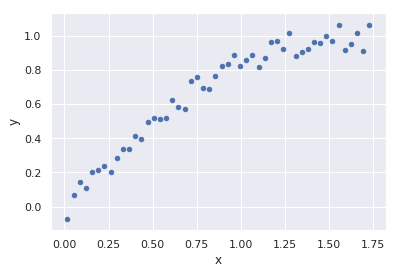

In [78]:
data.plot(kind="scatter", x="x", y="y")
plt.show()

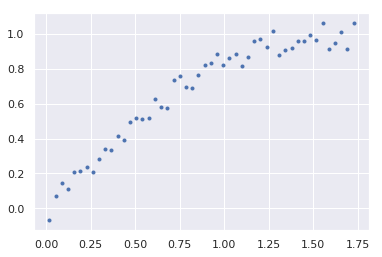

shape of x= (50, 4)
shape of y= (50,)


In [79]:
plt.plot(data['x'],data['y'],'.') # same as `plt.scatter(x = data['x'],y =data['y'])`
plt.show()
# 準備x^2,x^3,x^4次方項
for i in range(2,5):
    colname = 'x_%d'%i
    data[colname] = data['x']**i
# 整理好資料後，將其存回Numpy矩陣
y=data.iloc[:,0].values
x=data.iloc[:,1:].values
data.head(3)
# 檢查x,y矩陣的形狀為何
print('shape of x=',x.shape)
print('shape of y=',y.shape)

[回索引](#索引)

## 4. 開始對資料做線性回歸

In [82]:
x[0,:]

array([1.74532925e-02, 3.04617420e-04, 5.31657693e-06, 9.27917724e-08])

In [89]:
eps = 1.E-10

assert np.abs(x[0,1] - x[0,0]**2) < eps
assert np.abs(x[0,2] - x[0,0]**3) < eps
assert np.abs(x[0,3] - x[0,0]**4) < eps

#### 4.a. L1規範項可忽略 

In [94]:
batch_size=10
num_epochs=1000
infoStep=100
lr=0.01
C=10000  # C非常大，L1規範項可忽略
verbose=True

In [98]:
regressor= LinearRegression()
weights= np.random.normal(0,0.01,x.shape[1]+1) # 初始化權重向量
weights,loss= regressor.fit(x,y,weights,batch_size,C,num_epochs,
                            lr=lr,infoStep=infoStep,verbose=verbose) # 回歸開始
print('\n final weights=',weights)
y_pred=regressor.predict(weights,x) # 以所學之權重向量，來預測所輸入的x其y值為何


initial loss= 0.024457711974274623
epoch 100, loss= 0.0014541279560874995
epoch 200, loss= 0.0016264974605025347
epoch 300, loss= 0.0018962844746752048
epoch 400, loss= 0.0021166721229843623
epoch 500, loss= 0.002265578516906642
epoch 600, loss= 0.0023537437150708226
epoch 700, loss= 0.0023978589766590914
epoch 800, loss= 0.002412344744251835
epoch 900, loss= 0.0024077949398122376
epoch 1000, loss= 0.002391448022450296

 final weights= [ 0.12302109  0.5040168   0.288555    0.05129532 -0.135673  ]


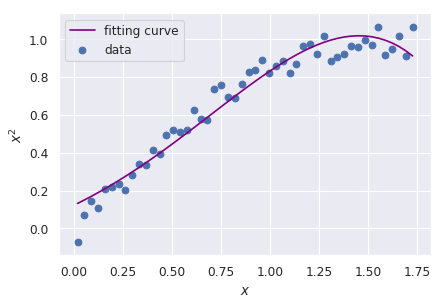

In [101]:
plt.figure(dpi=80)
plt.scatter(x[:,0],y,label='data') # 繪製原始資料
plt.plot(x[:,0],y_pred,label='fitting curve',ls='-',color='purple') # 繪製回歸結果
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$x^2$")
plt.show()

[回索引](#索引)

---

# a
## a
### a
#### a
##### a

---

$i\frac{\partial \Psi}{\partial t} = \mathbf{H}\Psi$

LaTeX

---

#### 4.b. 將C的數值減低，以增加L1規範項的影響

initial loss= 0.020832578809993514
epoch 100, loss= 0.0108405956384352
epoch 200, loss= 0.010798780763213263
epoch 300, loss= 0.01105974247624463
epoch 400, loss= 0.011231239723399651
epoch 500, loss= 0.011335478606075153
epoch 600, loss= 0.011400050702493163
epoch 700, loss= 0.011441098435586699
epoch 800, loss= 0.011464908207326987
epoch 900, loss= 0.011477660585711457
epoch 1000, loss= 0.011476533244764983

 final weights= [ 2.70768690e-01  3.93662510e-01  7.05490283e-02 -1.68411312e-04
 -1.17914882e-02]


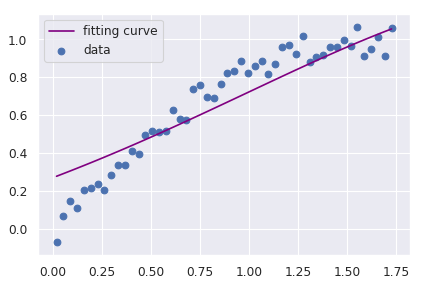

In [104]:
batch_size=10
num_epochs=1000
infoStep=100
lr=0.01
C=50  # C不是非常大，L1規範項不可忽略
verbose=True

regressor= LinearRegression()
weights= np.random.normal(0,0.01,x.shape[1]+1)
weights,loss= regressor.fit(x,y,weights,batch_size,C,num_epochs,
                            lr=lr,infoStep=infoStep,verbose=verbose)
print('\n final weights=',weights)
y_pred=regressor.predict(weights,x)

plt.figure(dpi=80,figsize=(6,4))
plt.scatter(x[:,0],y,label='data')
plt.plot(x[:,0],y_pred,label='fitting curve',ls='-',color='purple')
plt.legend()
plt.show()

[回索引](#索引)

## 5. 改變C, 由10000至10, 看回歸結果如何變化

In [105]:
np.logspace(4,1,6,dtype=np.int32)

array([10000,  2511,   630,   158,    39,    10], dtype=int32)

In [106]:
info=[]
for C in np.logspace(4,1,6,dtype=np.int32):
    print('\n C=',C)
    batch_size=10
    num_epochs=3000
    infoStep=100
    lr=0.01
    verbose=False

    regressor= LinearRegression()
    weights= np.random.normal(0,0.01,x.shape[1]+1)
    weights,loss= regressor.fit(x,y,weights,batch_size,C,num_epochs,
                                lr=lr,infoStep=infoStep,verbose=verbose)
    y_pred=regressor.predict(weights,x)
    
    info.append([weights,loss,y_pred,C])


 C= 10000
initial loss= 0.023947131674008987
epoch 3000, loss= 0.0019250056094945454

 C= 2511
initial loss= 0.021266834126085793
epoch 3000, loss= 0.002226930776053814

 C= 630
initial loss= 0.025216447944479154
epoch 3000, loss= 0.0032266182344297244

 C= 158
initial loss= 0.022014669859495035
epoch 3000, loss= 0.0064005583472428445

 C= 39
initial loss= 0.024117354953359517
epoch 3000, loss= 0.013844545747166714

 C= 10
initial loss= 0.02717793177565945
epoch 3000, loss= 0.01276618830679977


[回索引](#索引)

In [108]:
len(info)

6

#### 5.a. 將回歸結果繪圖

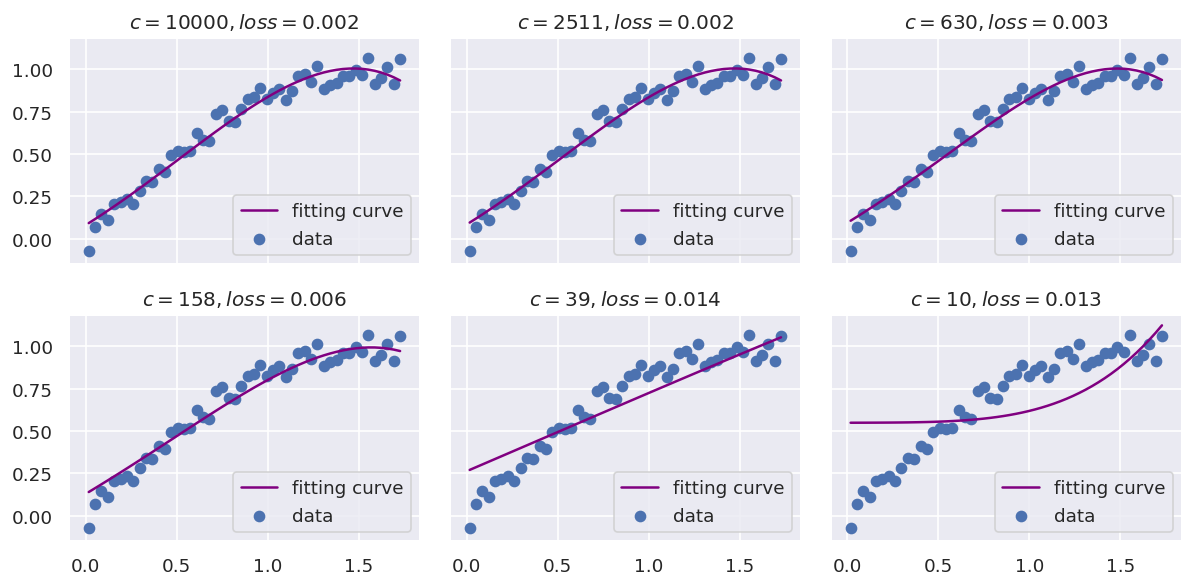

In [109]:
fig,axes=plt.subplots(2,3,sharey=True,sharex=True)
fig.set_size_inches(10,5)
fig.dpi=120
axes=axes.reshape(-1)
for idx,result in enumerate(info):
    
    weights=result[0]
    loss=result[1]
    y_pred=result[2]
    C=result[3]

    axes[idx].scatter(x[:,0],y,label='data')
    axes[idx].plot(x[:,0],y_pred,label='fitting curve',ls='-',color='purple')
    axes[idx].legend()
    axes[idx].set_title('$c=%i, loss=%.3f$'%(C,loss))
plt.tight_layout()

[回索引](#索引)

#### 5.b. 將權重繪圖

In [111]:
w=np.zeros((6,5))
c=np.zeros(6,dtype=np.int32)
for idx,result in enumerate(info):
    weights=result[0]
    C=result[3]
    w[idx,:]=weights
    c[idx]=C

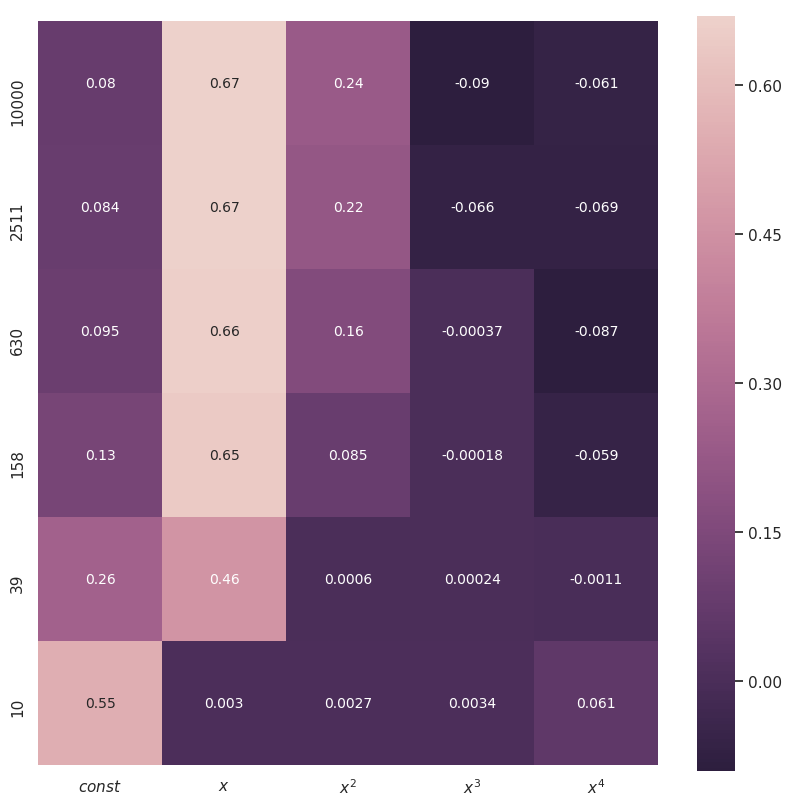

In [115]:
fig,ax=plt.subplots(figsize=(10,10))
fig.set_dpi(100)

s=sns.cubehelix_palette(reverse=True,as_cmap=True)
sns.heatmap(w,xticklabels=['$const$','$x$','$x^2$','$x^3$','$x^4$']
             ,yticklabels=c,cmap=s,ax=ax,annot=True, square=True)
plt.show()

[回索引](#索引)